# Analyzing Confederate Symbols
## Part 1: Package Imports and Getting Data

The dataset we'll be working with comes from the Southern Poverty Law Center, last updated February 1, 2019. The dataset contains data on 1481 Confederates symbols across the country. Note that in addition to monuments, this dataset also contains info on schools, roadways, etc memorializing the Confederacy. Features of interest are the following:
- **feature_name:** The name of the installation/symbol
- **address/city/state:** Full address of the monument divided across columns.
- **category:** The specific type of the symbol (i.e. monument, school name, etc.)
- **group_class:** Somewhat more general version of **category**.
- **year_dedicated:** Year the symbol was erected or created.
- **latitude/longitude:** The coordinates of the symbol's location.

In [1]:
import pandas as pd
import numpy as np
import random as rand

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import geoplot as gplt
import mapclassify as mc
from shapely.geometry import Point
import fiona

from scipy import stats
import statsmodels.api as sm
import patsy

%matplotlib inline

In [2]:
df = pd.read_csv('SPLC_dataset.csv')
df_rows = df.shape[0]
print('dataset dimensions: ' + str(df.shape))
df.head()

dataset dimensions: (1905, 14)


,Unique ID,feature_name,Honorees,City,County,State,Side,Coordinates,Symbol Type,Symbol Category,Sponsors,Year Dedicated,Year Removed,Tracking Status
0,5088,Monument of Confederate Soldier,NaN,Dover,Stewart,TN,Not Applicable,",",Monument,Monument,NaN,1933.0,NaN,Live
1,5089,Confederate Drive,NaN,Caledonia,Lowndes,MS,Not Applicable,",",Highway / Roadway,Roads,NaN,1986.0,NaN,Live
2,223,Confederate Oak,No specific honoree,Port Orange,Volusia,FL,South,"29.141516,-81.006682",Other,Parks/Trails,Uknown,NaN,NaN,Live
3,210,Confederate Monument,No specific honoree,St. Augustine,St. Johns,FL,South,"29.892467,-81.312033",Monument,Monument,Ladies Memorial Association,1872.0,NaN,Live
4,1983,Gen. William Loring Monument,William Loring,St. Augustine,St. Johns,FL,South,"29.892417,-81.313817",Monument,Monument,United Daughters of the Confederacy,1920.0,NaN,Live


Split `Coordinates` into latitude and longitude columns, drop symbols which have been removed for this analysis. We'll also drop the small number of data that are missing coordinates, and also remove symbols which are already gone.

In [3]:
miss_coord = df[df['Coordinates'] == ","].shape[0]
print(str(miss_coord/df_rows) + "% of rows missing coordinates.")

removed = df[df['Tracking Status'] != 'Live'].shape[0]
print((str(removed/df_rows) + "% of symbols have been removed."))

0.013123359580052493% of rows missing coordinates.
0.11496062992125984% of symbols have been removed.


In [4]:
# drop null coords
df = df[df['Coordinates'] != ","]
df = df.reset_index(drop=True)
df.drop(771, axis=0, inplace=True) # 770 had a weird partial input error

# convert coords to float, re-merge into df
coords = pd.DataFrame(df['Coordinates'].str.split(',').tolist())
coords = coords.astype(float)
coords = coords.rename(columns={0:'latitude', 1:'longitude'})
df = df.merge(coords, left_index=True, right_index=True)

# ONly include symbols which haven't been removed
df = df[df['Tracking Status'] == 'Live']

df = df.reset_index(drop=True)

print(df.shape)
df.head()

(1669, 16)


,Unique ID,feature_name,Honorees,City,County,State,Side,Coordinates,Symbol Type,Symbol Category,Sponsors,Year Dedicated,Year Removed,Tracking Status,latitude,longitude
0,223,Confederate Oak,No specific honoree,Port Orange,Volusia,FL,South,"29.141516,-81.006682",Other,Parks/Trails,Uknown,NaN,NaN,Live,29.141516,-81.006682
1,210,Confederate Monument,No specific honoree,St. Augustine,St. Johns,FL,South,"29.892467,-81.312033",Monument,Monument,Ladies Memorial Association,1872.0,NaN,Live,29.892467,-81.312033
2,1983,Gen. William Loring Monument,William Loring,St. Augustine,St. Johns,FL,South,"29.892417,-81.313817",Monument,Monument,United Daughters of the Confederacy,1920.0,NaN,Live,29.892417,-81.313817
3,187,Robert Lee Road,Robert E. Lee,St. Cloud,Osceola,FL,South,"28.194564,-81.173562",Highway / Roadway,Roads,Uknown,NaN,NaN,Live,28.194564,-81.173562
4,2104,Stonewall Jackson Memorial Highway Marker,"Thomas Jonathan ""Stonewall"" Jackson",St. Petersburg,Pinellas,FL,South,"30.411733,-83.911133",Marker,Monument,United Daughters of the Confederacy,1940.0,NaN,Live,30.411733,-83.911133


We need to drop any data that are out of bounds of possible latitudes and longitudes. Fortunately (as seen below) this results no data dropped.

In [5]:
df = df[(df['latitude'] < 90) & (df['latitude'] > -90)]
df = df[(df['longitude'] < 180) & (df['longitude'] > -180)]   #keep vals that are on the planet Earth
df.shape

(1669, 16)

## Part 2: Visualizing the Data
### Symbols Established Across the Years
In this part we plot out histograms/density plots showing how the **year of dedication** of symbols is distributed across the years. We will also plot **major historical events** that pertain to Reconstruction, the Lost Cause, and racial justice in the USA to see how they line up with the distribution.

In [6]:
sns.set_style('whitegrid')
# self compiled csv containing major relevant historical events in the 1900s
eventdf = pd.read_csv('civilwar/lostcause.csv')
eventdf = eventdf.sort_values(by='Year')
eventdf

,Year,Event
3,1877,Reconstruction Ends
1,1896,Plessy v. Ferguson
2,1909,NAACP Founded
0,1915,"""Birth of a Nation"" Theatrical Release"
6,1925,Peak of the KKK
4,1954,Civil Rights Movement Begins
5,1968,Civil Rights Act of 1968


In [7]:
nan_years = sum(df['Year Dedicated'].isna())
nan_years/df.shape[0]

0.4853205512282804

Unfortunately there's a lot of missingness in our data for year of dedication. We'll just avoid doing any computations with the year, but we'll still plot distributions under the assumption that our remaining ~55% of data is representative.

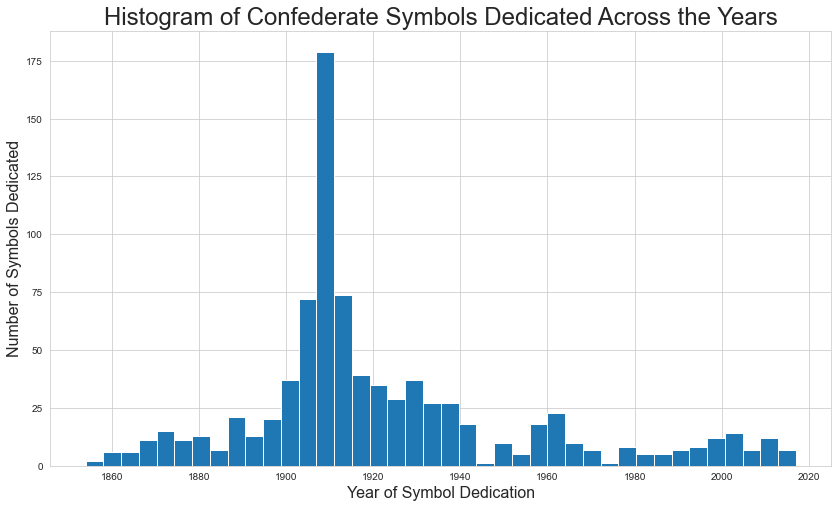

In [8]:
plt.figure(figsize=(14,8))
ax = plt.hist(df['Year Dedicated'].dropna(inplace=False), bins=40)
    
plt.xlabel("Year of Symbol Dedication", fontsize=16)
plt.ylabel("Number of Symbols Dedicated", fontsize=16)
plt.title('Histogram of Confederate Symbols Dedicated Across the Years', fontsize=24)
plt.savefig('histogram1.png', bbox_inches='tight')
plt.show()

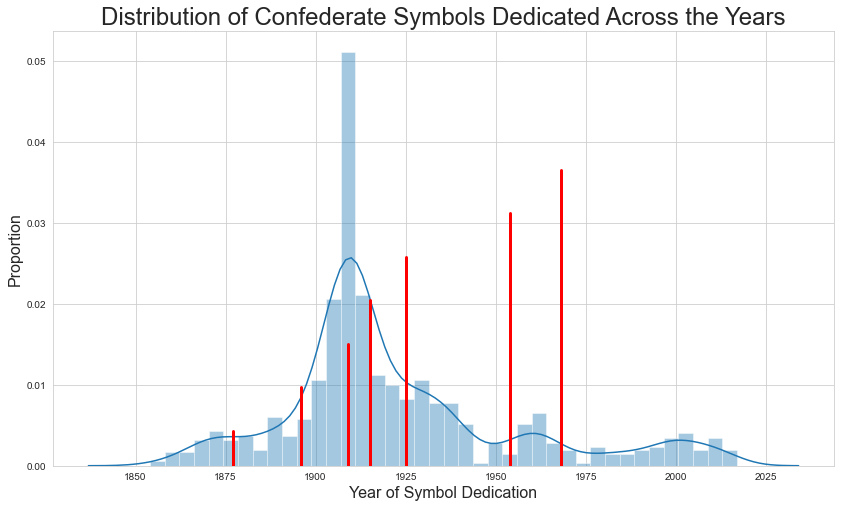

In [9]:
plt.figure(figsize=(14,8))
ax = sns.distplot(df['Year Dedicated'].dropna(), bins=40)

for i, year in enumerate(eventdf['Year'].tolist()):
    # plot major historical events as vertical lines of random height
    plt.axvline(year, ymax=i*0.10 + 0.08, color='red', linewidth=3)

plt.xlabel('Year of Symbol Dedication', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.title('Distribution of Confederate Symbols Dedicated Across the Years', fontsize=24)
plt.savefig('histogram2.png', bbox_inches='tight')
plt.show()

In [10]:
bin_years = (max(df['Year Dedicated'].dropna()) - min(df['Year Dedicated'].dropna()))/40
print("Bin size is " + str(bin_years) + " years.")

Bin size is 4.075 years.


So we see that symbols have largely gone up in the early 1900s (when the last Civil War veterans began to pass away), as well as the 1960s and slightly again in the early 2000s.  

This more or less lines up with the rise of the Lost Cause movement in the early 1900s, as well as the Civil Rights Movement in the mid 1960s. 

It's important to note also that monuments began to steadily rise for the first time after Reconstruction ended in 1877, and after Jefferson Davis published "The Rise and Fall of the Confederate Government" largely considered to be a major work that kicked off the Lost Cause movement.

### Symbols Across the Country
In this part we'll explore the geographical distribution of Confederate symbolism and try to answer these questions:
- Where do Confederate symbols tend to be located?
- What kind of symbols are there, and where are certain types concentrated?
- How is location related to the Civil War?

In [11]:
# keep 5 biggest types, merge all else
types = df['Symbol Type'].value_counts().keys().tolist()[0:5]

df['plot_class'] = df['Symbol Type']
df.loc[~df['Symbol Type'].isin(types),'plot_class'] = 'Other'   # label anything that's not in top 5 as other

Then get the map of all US states to use as a backdrop:

In [12]:
# map of all 50 states from the US Census Bureau, 
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
statemap = gpd.read_file('statemaps/cb_2018_us_state_500k.shp')

#drop to contiguous 48
statemap = statemap[(statemap['STATEFP'] != '02') & 
                      (statemap['STATEFP'] != '15') &
                      (statemap['STATEFP'] != '60') &
                      (statemap['STATEFP'] != '66') &
                      (statemap['STATEFP'] != '69') &
                      (statemap['STATEFP'] != '72') &
                      (statemap['STATEFP'] != '78')]

statemap.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [13]:
# map of all US counties, from US Census Bureau
countymap = gpd.read_file('countymaps/cb_2018_us_county_500k.shp')

#drop to contiguous 48
countymap = countymap[(countymap['STATEFP'] != '02') & 
                      (countymap['STATEFP'] != '15') &
                      (countymap['STATEFP'] != '60') &
                      (countymap['STATEFP'] != '66') &
                      (countymap['STATEFP'] != '69') &
                      (countymap['STATEFP'] != '72') &
                      (countymap['STATEFP'] != '78')]

We can color the state map by allegiance during the Civil War:

In [14]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)  # data on monuments packed into geodf

# states listed by allegiance
csa_list = ['South Carolina','Texas','Mississippi','Florida','Alabama','Georgia','Louisiana','Virginia','Arkansas',
           'Tennessee','North Carolina']
contested_list = ['Missouri','Kentucky', 'Maryland', 'Delaware', 'West Virginia']
territories = ['Washington','Idaho','Montana','Arizona','New Mexico','Wyoming','Utah','Colorado','Oklahoma','Nebraska',
               'North Dakota','South Dakota']

# assign allegiance column
statemap['ALLEG'] = 'USA'
statemap.loc[statemap['NAME'].isin(csa_list), 'ALLEG'] = 'CSA'
statemap.loc[statemap['NAME'].isin(contested_list), 'ALLEG'] = 'Contested'
statemap.loc[statemap['NAME'].isin(territories), 'ALLEG'] = 'Territories'

In [15]:
# creating color map for state allegiance (historical colors)
civil_cmap = plt.cm.get_cmap('Set1', 4)
civil_cmap = civil_cmap(np.linspace(0,1,4))
civil_cmap[0,:3] = colors.to_rgb('grey')
civil_cmap[1,:3] = colors.to_rgb('darkslategray')
civil_cmap[2,:3] = colors.to_rgb('white')
civil_cmap[3,:3] = colors.to_rgb('C0')
civil_cmap[:,3] = 0.75

cmap = colors.LinearSegmentedColormap.from_list('civil_war', civil_cmap)

Now plot all symbols' geographic location as a simple point plot on the US Map. (Note: Mercator projection was used for this whole analysis)

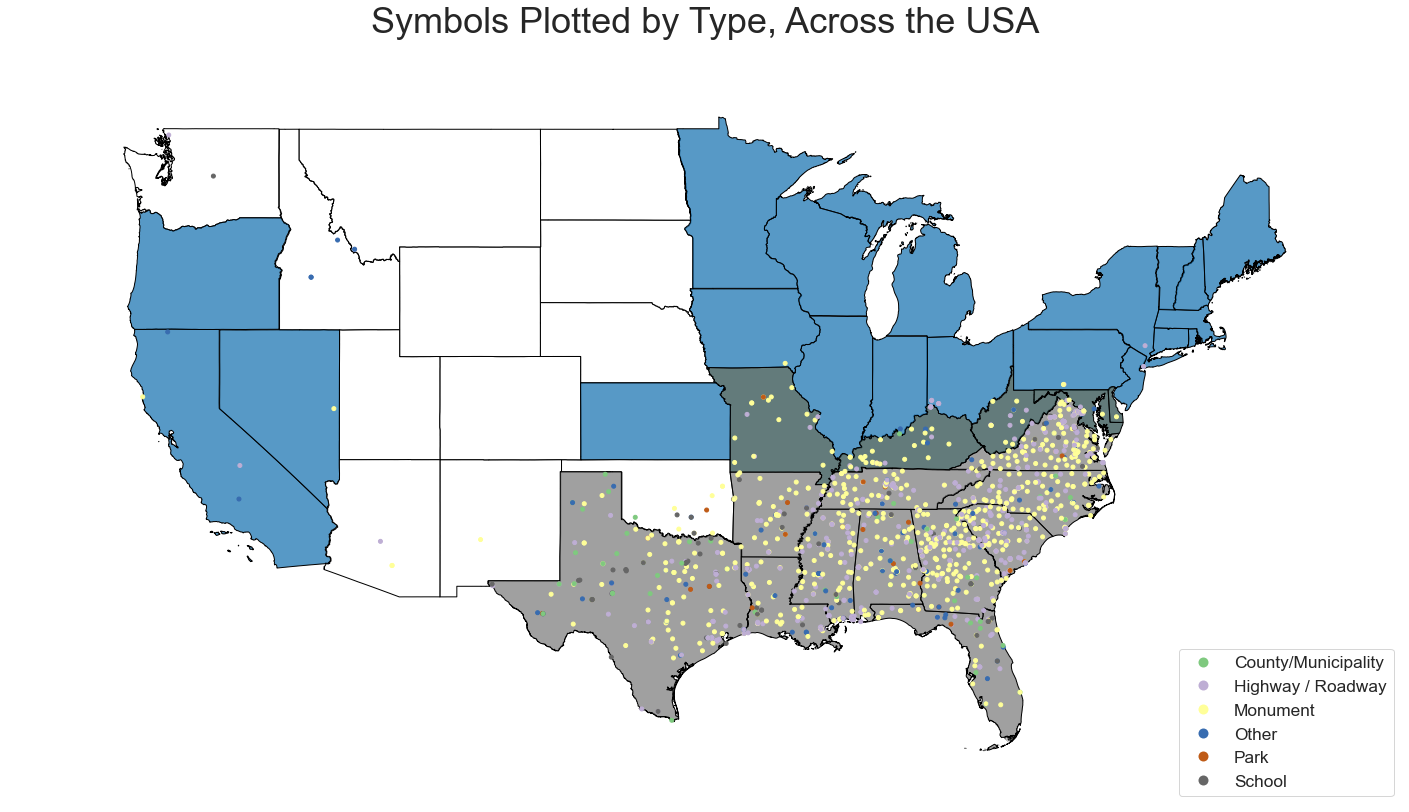

In [16]:
# plot symbol locations across civil war map
ax = gplt.pointplot(gdf, projection=gplt.crs.Mercator(), hue='plot_class', cmap='Accent', legend=True,
                    legend_kwargs={'loc':'lower right','fontsize':'xx-large'}, figsize=(25,25),
                    s=4)
gplt.choropleth(statemap, ax=ax, hue='ALLEG', edgecolor='Black', cmap = cmap, projection=gplt.crs.Mercator(), zorder=0)

plt.title('Symbols Plotted by Type, Across the USA', fontdict={'fontsize':36})
plt.savefig('symbol_pointplot.png', bbox_inches='tight')
plt.show()

Former Union states are labeled blue (including Nevada which was added during the war), former Confederate states are labeled grey, and border states (which remained in the Union but allowed slavery) are labeled green. White states were still unincorporated territories during the war.  

It's worth noting that territories that now make up Arizona, New Mexico, and Oklahoma allowed slavery.

In [17]:
df['plot_class'].value_counts()

Monument               723
Highway / Roadway      639
Other                  125
School                  91
County/Municipality     56
Park                    35
Name: plot_class, dtype: int64

In [18]:
df['plot_class'].value_counts(normalize=True)

Monument               0.433194
Highway / Roadway      0.382864
Other                  0.074895
School                 0.054524
County/Municipality    0.033553
Park                   0.020971
Name: plot_class, dtype: float64

The relative percentages of each symbol type are listed above. We can see that monuments and road names make up the vast majority of symbols.

Now we can plot out a **2D density plot** of where symbols tend to be concentrated. In this analysis plot titles use "concentration" instead of "density" for accessibility.

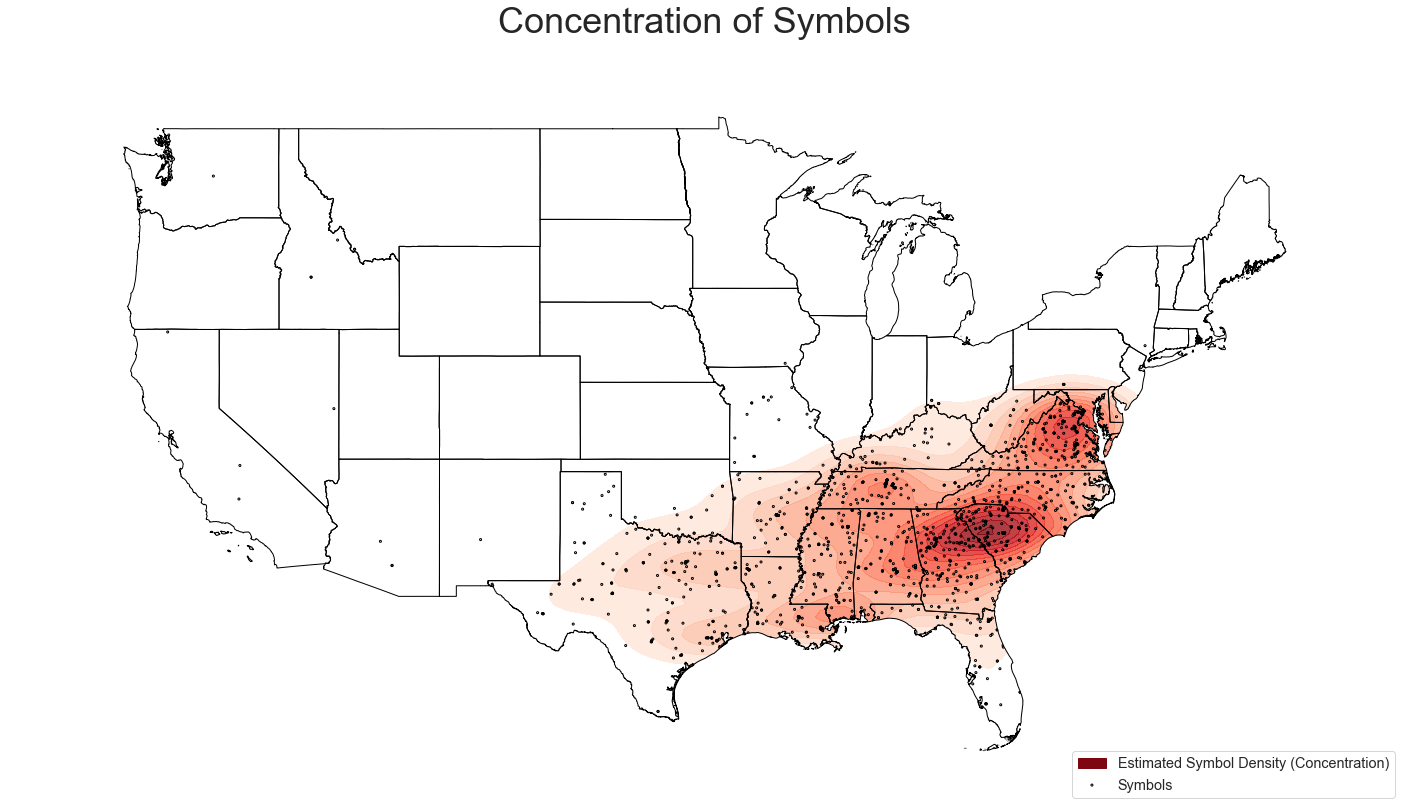

In [19]:
# plot symbol concentration across vanilla US map
ax = gplt.kdeplot(
    gdf, clip=statemap['geometry'],
    shade=True, cmap='Reds',
    projection=gplt.crs.Mercator(),
    n_levels=15,
    figsize=(25,25),
    zorder=0,
    alpha=0.8,
    label='Estimated Symbol Density (Concentration)')
gplt.pointplot(gdf, ax=ax, s=2, color='none', edgecolors='black', zorder=1, label='Symbols')
gplt.polyplot(statemap, ax=ax, zorder=2)

plt.title('Concentration of Symbols', fontdict={'fontsize':36})
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('symbol_kdeplot.png', bbox_inches='tight')
plt.show()

Confederate symbols tend to be concentrated almost exclusively in former CSA states, with most of the remaining symbols in border states.

## Part 3: Demographics and Confederate Symbols
### Geographic Data
In this part, we will explore the relationship between demographics and the density of Confederate symbols. Specifically, we will look at how the population percentage of white people vs Black people interacts with the density of Confederate symbols at the county level.

First, we get the necessary county-level Census demographic data. Note that rather than being pulled directly from the Census, these data were pulled from Kaggle where race percentages (rather than just raw numbers) had already been calculated.

In [20]:
#demographic data from 2017 US Census
censusdf = pd.read_csv('censusdata/acs2017_county_data.csv')
censusdf.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [21]:
def add_census(feature):
    '''Adds a feature from the census_df to the countymap. This puts census data into geographical perspective 
       (matches census data to the county map for choropleth)
    '''
    interdf = censusdf[['CountyId', feature]]    # interdf placeholder stores feature of interest and corresponding countyid
    interdf = interdf.rename(columns={'CountyId':'GEOID'})    # change name for county code to match on county id
    return countymap.merge(interdf, on='GEOID')

In [22]:
# this section adds features from the census matched along county id
countymap['GEOID'] = countymap['GEOID'].astype(int)    # original read in as str
countymap = add_census('Black')
countymap = add_census('White')

We can first plot the demographic percentage data across counties just to get a feel for which areas have a large Black majority and a large white majority.  

The darker the county color, the greater the percentage of that county's population that belongs to the given ethnicity.

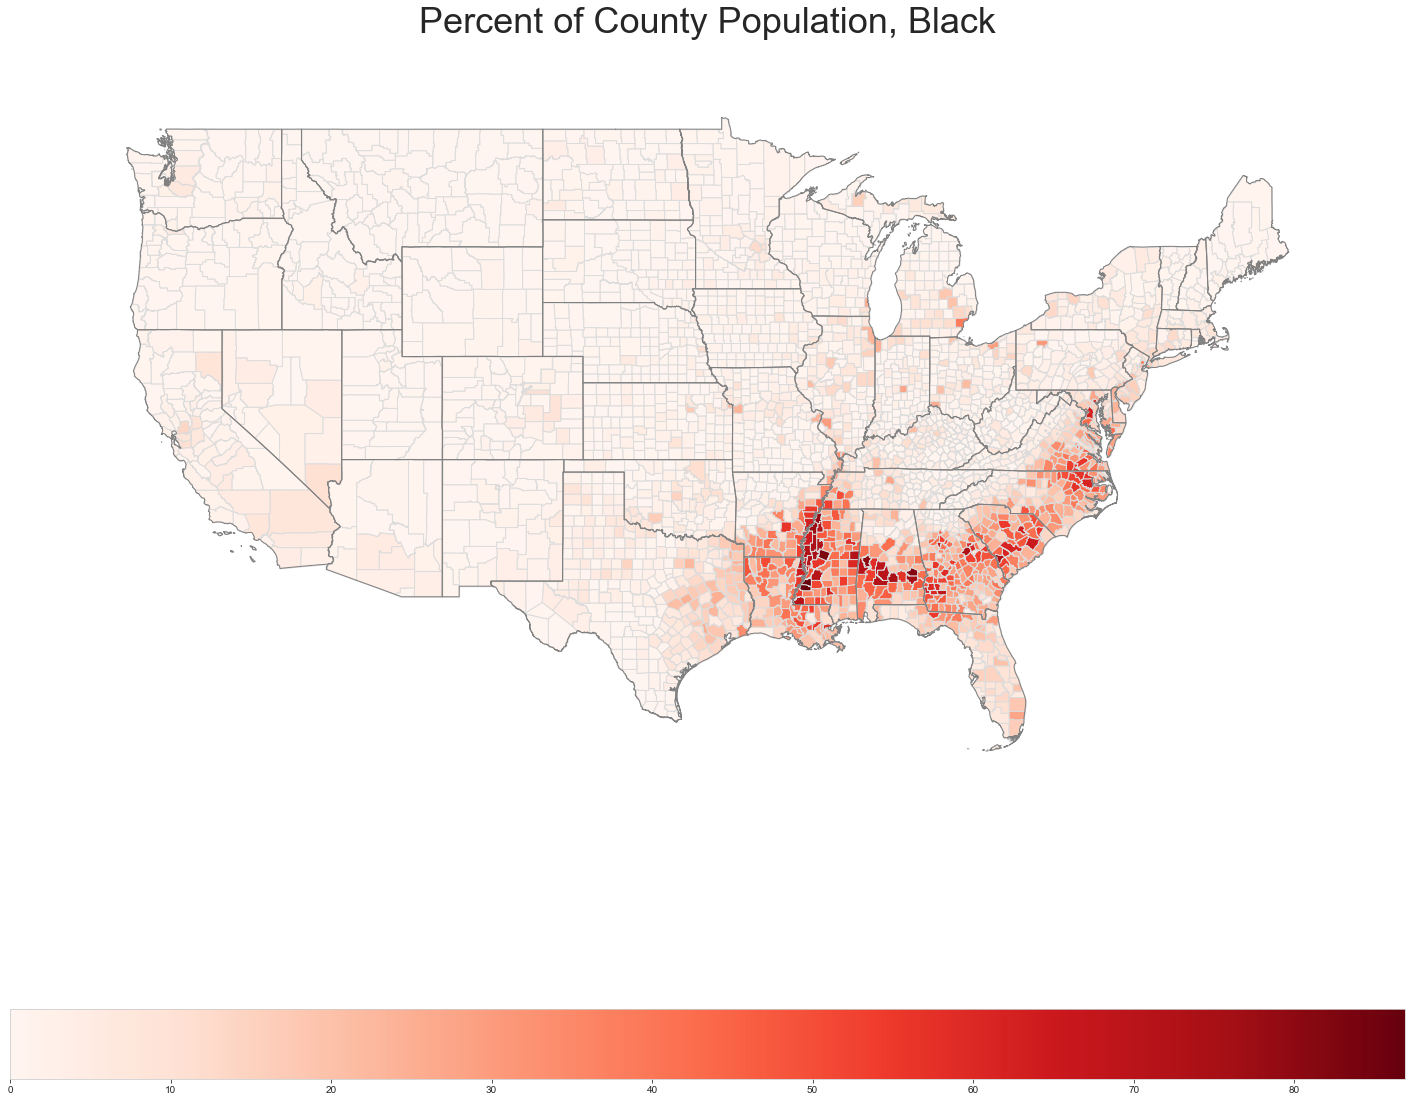

In [23]:
# plot counties by % of population who are black
ax = gplt.choropleth(countymap, projection=gplt.crs.Mercator(), hue=countymap['Black'], cmap='Reds', 
                     edgecolor='gainsboro', figsize=(25, 25), legend=True,
                     legend_kwargs={'orientation':'horizontal'})
gplt.polyplot(statemap, ax=ax, edgecolor='Grey', zorder=1)

plt.title('Percent of County Population, Black', fontdict={'fontsize':36})
plt.savefig('black_choropleth.png', bbox_inches='tight')
plt.show()

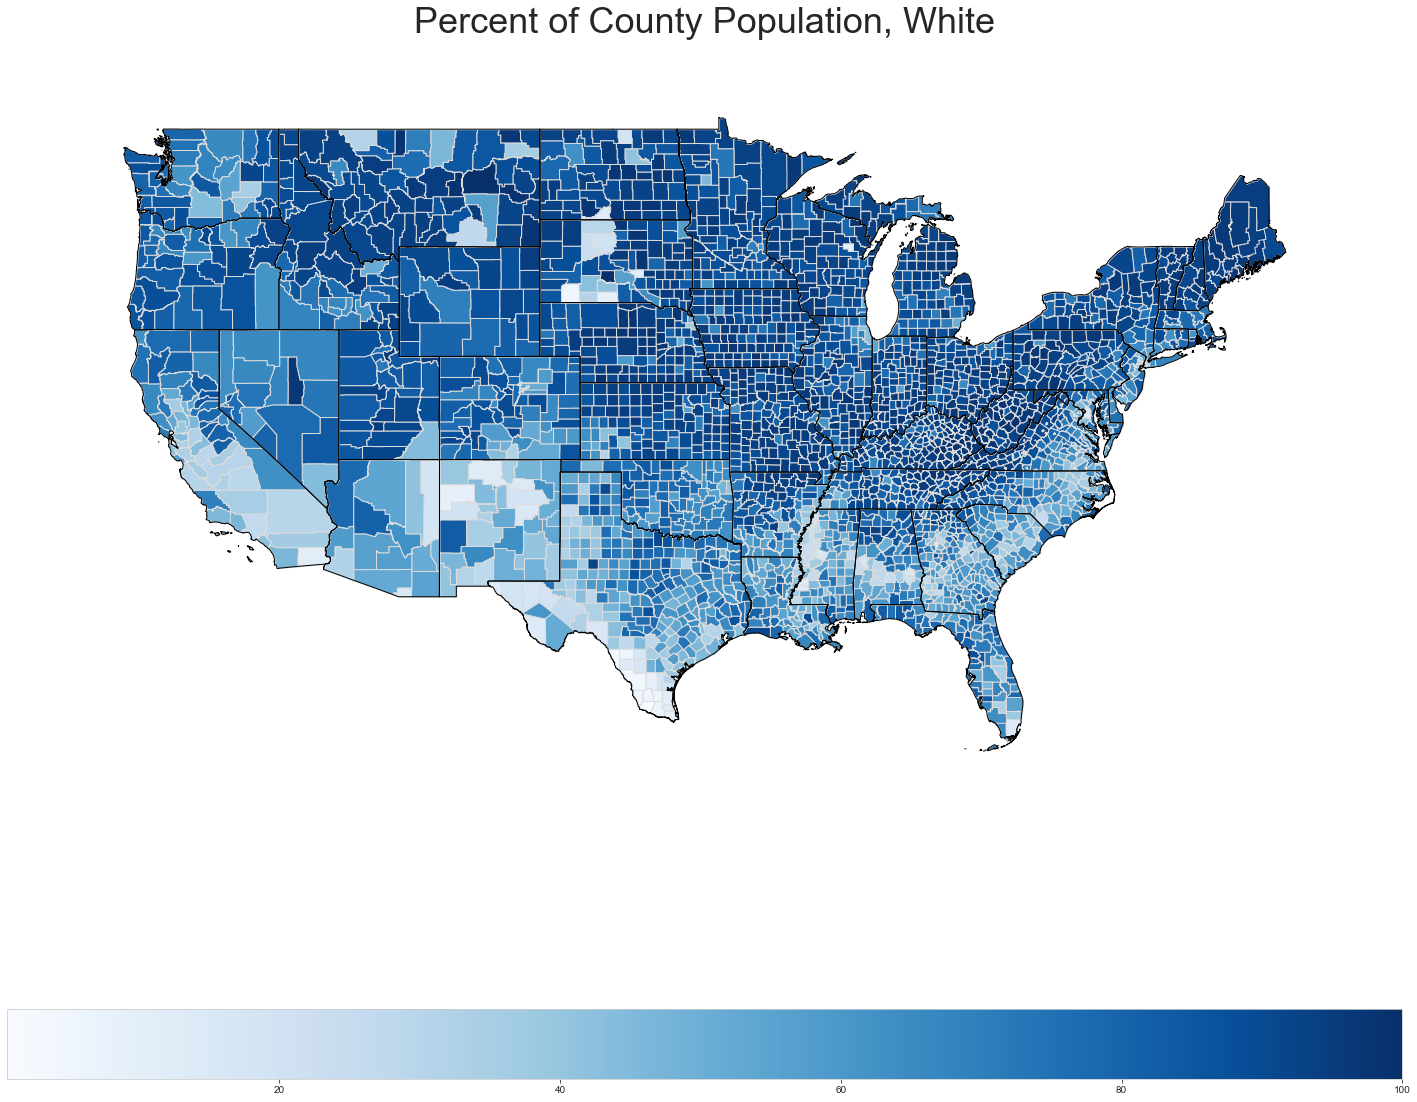

In [24]:
ax = gplt.choropleth(countymap, projection=gplt.crs.Mercator(), hue=countymap['White'], cmap='Blues',
                     edgecolor='gainsboro', figsize=(25, 25), legend=True,
                     legend_kwargs={'orientation':'horizontal'})
# gplt.choropleth(countymap, ax=ax, projection=gplt.crs.Mercator(), hue=countymap['Black'], cmap='Reds',
#                 alpha=0.5)
gplt.polyplot(statemap, ax=ax, edgecolor='Black', zorder=1)

plt.title('Percent of County Population, White', fontdict={'fontsize':36})
plt.savefig('white_choropleth.png', bbox_inches='tight')
plt.show()

Now we can combine these plots into one overarching choropleth map that shows how the white population percentage compares to the Black population percentage in any given county. This is calculated by black%-white%, so more blue means a larger white majority, more red means a larger Black majority, and white means roughly even population percentages.

Note that this doesn't take into account other ethnicities that may have a large population in a given county. For our area of interest this doesn't really pose a major problem since most people in the area we'll be looking at are either white or Black.  
We can also overlay the 2D distribution plot for Confederate symbols over this map to see how the difference in population percentages interacts with the distribution of symbols.

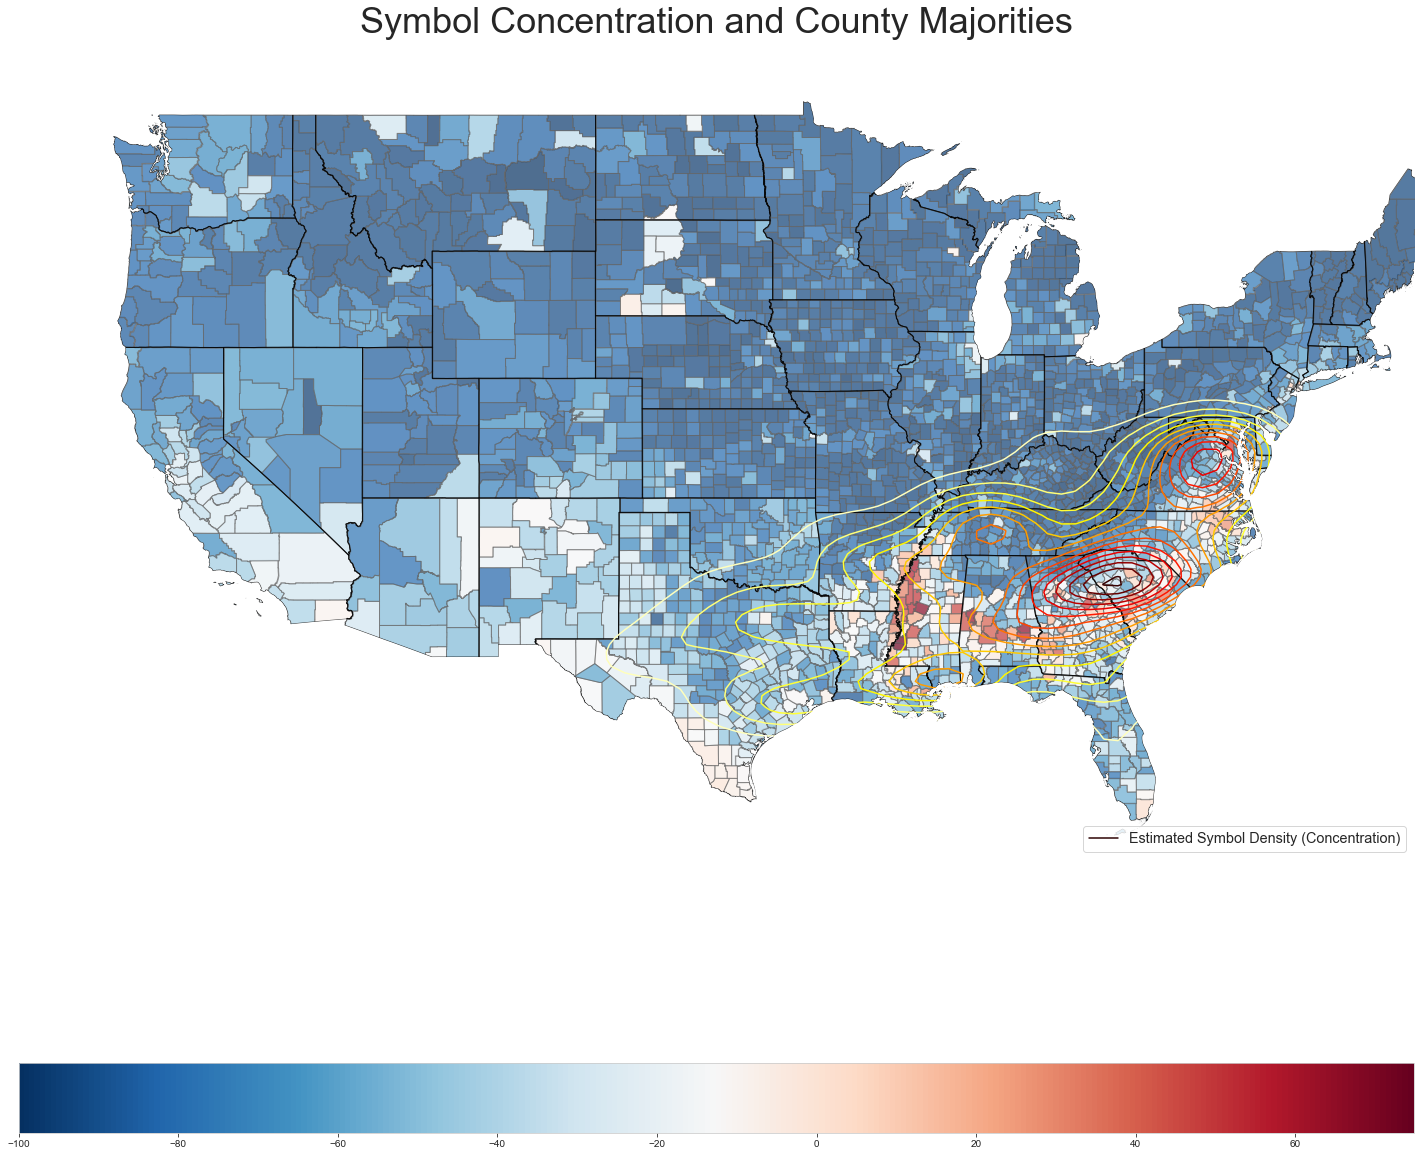

In [25]:
countymap['b-w'] = countymap['Black'] - countymap['White']

# plot counties by gap in percent
ax = gplt.choropleth(countymap, projection=gplt.crs.Mercator(), hue=countymap['b-w'], cmap='RdBu_r', figsize=(25, 25),
                    edgecolor='dimgrey', legend=True, legend_kwargs={'orientation':'horizontal'}, alpha=0.70)

gplt.polyplot(statemap, ax=ax, edgecolor='Black', alpha = 0.70, zorder=1)

#save without kdeplot
plt.title('County Population Percentage Gap', fontdict={'fontsize':36})
plt.savefig('bw_choropleth.png', bbox_inches='tight')
# overlay kdeplot from before without fill
gplt.kdeplot(
    gdf, ax = ax,
    clip=statemap['geometry'],
    cmap='hot_r',
    n_levels=15,
    shade=False,
    projection=gplt.crs.Mercator(),
    label='Estimated Symbol Density (Concentration)')

plt.title('Symbol Concentration and County Majorities', fontdict={'fontsize':36})
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('bw_heatmap.png', bbox_inches='tight')
plt.show()

There appear to be some interesting interactions in various places, but one thing that's clear is that there's a **heavy concentration in areas where white% and black% are roughly even, or where black% is higher**. Now we can attempt to actually quantify this by calculating the average demographics in areas with a **high symbol concentration** vs **low symbol concentration**.

### Quantifying Demographics in Low Density vs High Density Regions

We will use Gaussian KDE to estimate the density of symbols in the regions of interest. The game plan will be as follows:
1. **Obtain the coordinates for the center of each county** so we can have a single density number for each county  

2. **Cut off all counties not in the former CSA** for this part of the analysis, as this is where almost all monuments are located. We do this because we want our frame of reference to be where monuments actually are; that is, we want to know if areas with a high density of monuments has different demographics compared to areas of low density, rather than *no* density. This will allow us to obtain more precise statistics, and though our scope is reduced to Southern states only, we lose little generality since this is where monuments are anyway.

3. **Build a Gaussian KDE model** off the coordinates obtained in (1) that we can use to give us the estimated density at any geographical coordinate.  

4. Using the model from (3), **calculate the densities of all counties** and look for patterns in high-density counties vs low-density counties.

In [29]:
# creating a new df for centroids. Will include stateIDs so we can cut off specific parts of the country
centr_df = gpd.GeoDataFrame({'geometry':countymap['geometry'].centroid, 
                             'STATEFP':countymap['STATEFP'],
                             'Black':countymap['Black'],
                             'White':countymap['White'],
                             'b-w':countymap['b-w']})
centr_df = centr_df.merge(statemap[['STATEFP','ALLEG']], on='STATEFP')   # getting allegiance from our statemap from earlier
# cut off areas with almost no monuments (to preserve a valid median)
centr_df = centr_df[(centr_df['ALLEG'] != 'USA') &
                    (centr_df['ALLEG'] != 'Territories')]
centr_df.head()

,geometry,STATEFP,Black,White,b-w,ALLEG
0,POINT (-88.99926 37.05848),21,3.9,93.0,-89.1,Contested
1,POINT (-84.21715 38.20673),21,7.2,85.2,-78.0,Contested
2,POINT (-86.68162 37.20728),21,0.4,95.1,-94.7,Contested
3,POINT (-83.96431 37.69244),21,0.1,97.6,-97.5,Contested
4,POINT (-83.69666 38.37012),21,1.7,96.1,-94.4,Contested


Since we dropped areas not in the old Union or Territories, this part looks primarily at Southern states.

In [30]:
# get coordinates from 'geometry' as numeric cols
centr_df['latitude'] = [point.xy[1][0] for point in centr_df['geometry']]
centr_df['longitude'] = [point.xy[0][0] for point in centr_df['geometry']]
centr_df.head()

,geometry,STATEFP,Black,White,b-w,ALLEG,latitude,longitude
0,POINT (-88.99926 37.05848),21,3.9,93.0,-89.1,Contested,37.058482,-88.999256
1,POINT (-84.21715 38.20673),21,7.2,85.2,-78.0,Contested,38.206735,-84.217151
2,POINT (-86.68162 37.20728),21,0.4,95.1,-94.7,Contested,37.207285,-86.681623
3,POINT (-83.96431 37.69244),21,0.1,97.6,-97.5,Contested,37.692444,-83.964311
4,POINT (-83.69666 38.37012),21,1.7,96.1,-94.4,Contested,38.370118,-83.696656


In [31]:
# build kernel from monument density data
monum_arr = df[['latitude','longitude']].to_numpy()
kernel = stats.gaussian_kde(monum_arr.T)

In [32]:
# calculate estimated density for each centroid, add as new col
county_arr = centr_df[['latitude','longitude']].to_numpy()
centr_df['kde'] = kernel(county_arr.T)
print(centr_df.shape)
centr_df.head()

(1459, 9)


,geometry,STATEFP,Black,White,b-w,ALLEG,latitude,longitude,kde
0,POINT (-88.99926 37.05848),21,3.9,93.0,-89.1,Contested,37.058482,-88.999256,0.002203
1,POINT (-84.21715 38.20673),21,7.2,85.2,-78.0,Contested,38.206735,-84.217151,0.001529
2,POINT (-86.68162 37.20728),21,0.4,95.1,-94.7,Contested,37.207285,-86.681623,0.002960
3,POINT (-83.96431 37.69244),21,0.1,97.6,-97.5,Contested,37.692444,-83.964311,0.001980
4,POINT (-83.69666 38.37012),21,1.7,96.1,-94.4,Contested,38.370118,-83.696656,0.001480


In [33]:
centr_df['kde'].describe()

count    1459.000000
mean        0.004334
std         0.002910
min         0.000051
25%         0.001923
50%         0.004027
75%         0.006198
max         0.012710
Name: kde, dtype: float64

In [34]:
# split density estimates into lower 50%, upper 50% of density (on median)
k_med = centr_df['kde'].median()
print('b% - w% mean in lower, upper 50% of densities:')
print(centr_df[centr_df['kde'] < k_med]['b-w'].mean())
print(centr_df[centr_df['kde'] > k_med]['b-w'].mean())

b% - w% mean in lower, upper 50% of densities:
-65.22894375857338
-43.188751714677636


In [35]:
k_75 = centr_df['kde'].quantile(q=0.9)  # 75th quantile (highest density regions)
print('b% - w% mean in lower 75%, upper 25% of densities:')
print(centr_df[centr_df['kde'] < k_75]['b-w'].mean())
print(centr_df[centr_df['kde'] > k_75]['b-w'].mean())

b% - w% mean in lower 75%, upper 25% of densities:
-56.410205635948216
-34.600684931506855


This suggests that on average, counties with a higher density of monuments have a higher percentage of Black citizens. Now, to obtain a more precise characterization, we can plot b%-w% against monument density:

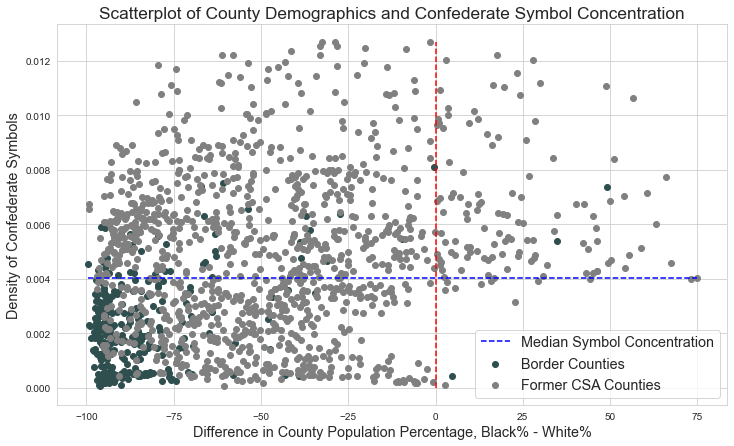

In [36]:
plt.figure(figsize=(12,7))
plt.scatter(centr_df[centr_df['ALLEG'] == 'Contested']['b-w'], 
            centr_df[centr_df['ALLEG'] == 'Contested']['kde'],
            c='darkslategray',
            label='Border Counties')
plt.scatter(centr_df[centr_df['ALLEG'] == 'CSA']['b-w'],
            centr_df[centr_df['ALLEG'] == 'CSA']['kde'],
            c='grey',
            label='Former CSA Counties')
plt.plot(np.zeros(50), np.linspace(0, centr_df['kde'].max()), 'r--')
plt.plot(np.linspace(centr_df['b-w'].min(), centr_df['b-w'].max()), k_med*np.ones(50), 'b--', 
         label='Median Symbol Concentration')

plt.xlabel('Difference in County Population Percentage, Black% - White%', fontsize='x-large')
plt.ylabel('Density of Confederate Symbols', fontsize='x-large')
plt.title('Scatterplot of County Demographics and Confederate Symbol Concentration', fontsize='xx-large')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('bw_scatter.png', bbox_inches='tight')
plt.show()

The data cloud doesn't really lend itself nicely to regression. This is definitely an unusual pattern but something is definitely going on.  

Notably, **almost none of the counties of interest with a black majority** had what we would consider a low monument density. Counties of interest with a white majority tended to have somewhat lower density, but many had high density as well. Counties with a black majority almost exclusively had a high density.  

Also worth nothing the gap in the lower-middle part of the data cloud. This suggests that **very few slight white-majority counties have a LOW concentration of confederate symbolism.**  

Remember, we're really only looking at states that tend have a high Black population. So Black-majority counties having a high concentration of confederate symbols isn't a result of symbols just being concentrated in the former CSA.

- Note: Adding in Union and Territory states keeps the above plot almost exactly the same, except that the Median Symbol Concentration moves way down to the bottom as we'd expect (since density is so low in those two regions).

We continue to try to characterize these data more precisely:

In [37]:
# num of black majority counties with above median density vs leq median density
abovemed = centr_df[(centr_df['b-w'] >= 0) & (centr_df['kde'] > k_med)].shape[0]
belowmed = centr_df[(centr_df['b-w'] >= 0) & (centr_df['kde'] <= k_med)].shape[0]
# Note: nowhere does 'b-w' == 0; >= choice arbitrary
total = centr_df[centr_df['b-w'] >= 0].shape[0]

# now for white majority
abovemedw = centr_df[(centr_df['b-w'] < 0) & (centr_df['kde'] > k_med)].shape[0]
totalw = centr_df[centr_df['b-w'] < 0].shape[0]

print('{}/{} with a higher Black population percentage have an above-median monument density,'.format(abovemed, total))
print('compared to {}/{} which have a below or equal to median monument density.'.format(belowmed, total))
print()
print('That is, out of all counties with a higher Black population percentage,')
print('{}% have an above-median monument density.'.format(abovemed/total*100))
print()
print('This is compared to {}/{}, or {}% of white majority communities with an above-median monument density.'.format(abovemedw,totalw,
                                                                                                             abovemedw/totalw*100))

114/127 with a higher Black population percentage have an above-median monument density,
compared to 13/127 which have a below or equal to median monument density.

That is, out of all counties with a higher Black population percentage,
89.76377952755905% have an above-median monument density.

This is compared to 615/1332, or 46.171171171171174% of white majority communities with an above-median monument density.


We can also perform a t-test on the subset of counties with a greater Black population percentage. If there was no real difference, we would expect a large p-value when comparing this to the subset with a greater white population percentage.

In [38]:
black_maj = centr_df[centr_df['b-w'] >= 0]
white_maj = centr_df[centr_df['b-w'] < 0]

# get ndarray for ttest
b_dens = black_maj['kde'].to_numpy()
w_dens = white_maj['kde'].to_numpy()

In [39]:
#t-test on white vs black means
stats.ttest_ind(w_dens, b_dens)

Ttest_indResult(statistic=-8.468867903650647, pvalue=5.96542977815463e-17)

The probability of this being a result of random chance is almost zero. This is definitely a statstically significant difference.

Without border states, it appears that white-majority counties tend to be evenly distributed across densities. Black majority counties still all have very high monument densities.

## Part 4: The Civil War and Confederate Symbols
Now, we also take a look at the "part of history" argument to see how historical events/figures might be tied geographically to the dedication of Confederate symbols. Namely, we want to know:
- Do Confederate symbols tend to be clustered in regions that saw a high number of major battles during the Civil War?
- Do Confederate symbols tend to be clustered in regions where Confederate leaders were born?

### Battles
First we'll get open source data on 189 major battles from the Civil War (from Wikipedia) and put these on the map. We can compare clusters of major battles with how monuments are distributed.

In [40]:
battledf = gpd.GeoDataFrame()

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# reading in multilayer kml file; must read in one layer at a time.
for layer in fiona.listlayers('civilwar/doc.kml'):
    s = gpd.read_file('civilwar/doc.kml', driver='KML', layer=layer)
    battledf = battledf.append(s, ignore_index=True)
    
print('Data on {} battles obtained.'.format(battledf.shape[0]))
battledf.head()

Data on 189 battles obtained.


,Name,Description,geometry
0,Battle of Plains Store,"<br>Source: Wikipedia article <a href=""https:/...",POINT Z (-91.20600 30.69000 0.00000)
1,Action off Galveston Light,"<br>Source: Wikipedia article <a href=""https:/...",POINT Z (-94.65717 29.31993 0.00000)
2,Attack on USS New Ironsides,"<br>Source: Wikipedia article <a href=""https:/...",POINT Z (-79.84300 32.72500 0.00000)
3,Bahia incident,"<br>Source: Wikipedia article <a href=""https:/...",POINT Z (-38.59722 -12.85417 0.00000)
4,Battle of Elizabeth City,"<br>Source: Wikipedia article <a href=""https:/...",POINT Z (-76.14210 36.27420 0.00000)


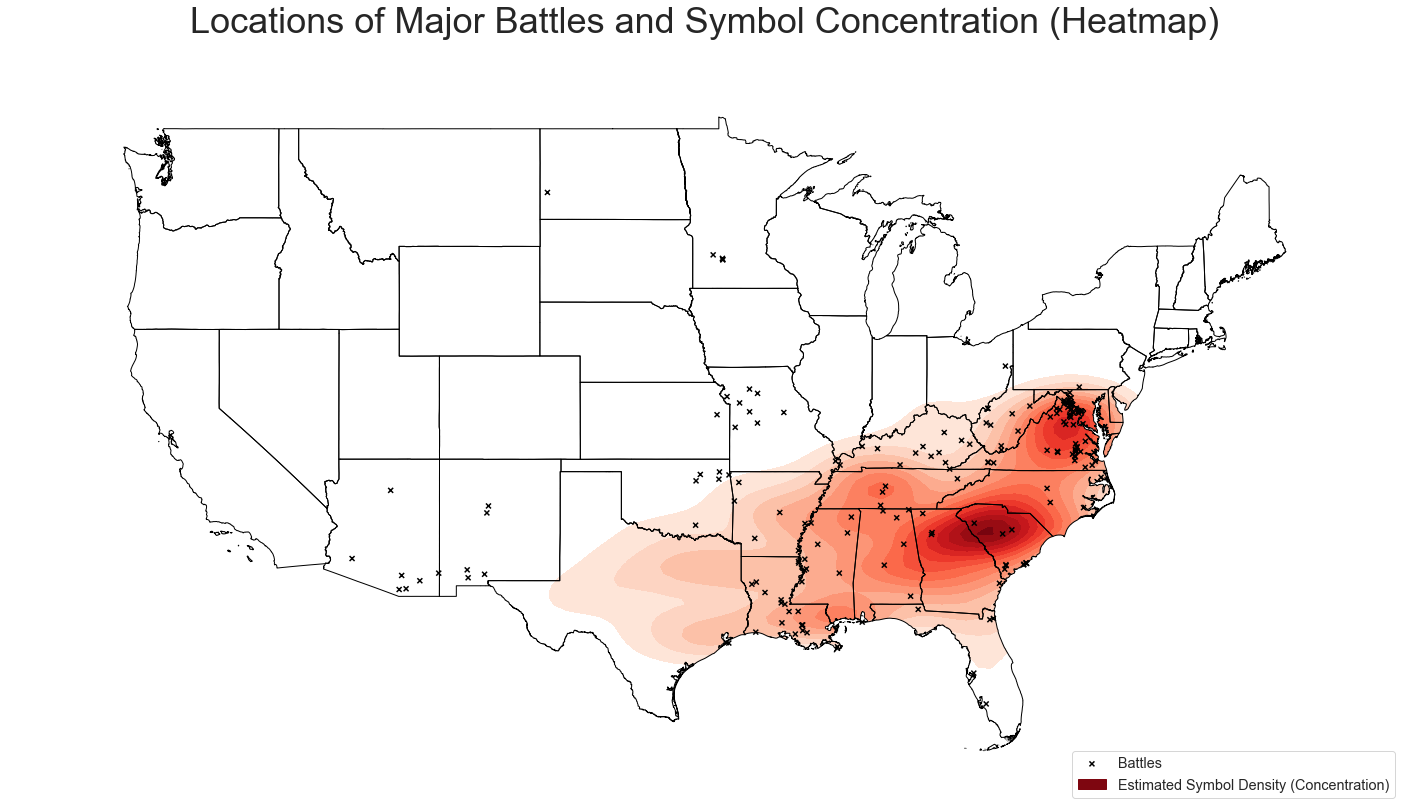

In [41]:
ax = gplt.pointplot(battledf, projection = gplt.crs.Mercator(), color='black', marker='x', zorder=3, figsize=(25,25),
                    label='Battles')
gplt.kdeplot(gdf, ax=ax, clip=statemap['geometry'], cmap='Reds', n_levels=15, shade=True,
             label='Estimated Symbol Density (Concentration)')
gplt.polyplot(statemap, ax=ax, zorder=2)

plt.title('Locations of Major Battles and Symbol Concentration (Heatmap)', fontdict={'fontsize':36})
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('battles_heatmap.png', bbox_inches='tight')
plt.show()

Above shows where battles occurred on the **heatmap** of symbol density. Below shows **raw symbol coordinates** rather than heatmap.  

These plots show us that, for the most part, symbols don't seem to be concentrated where battles occurred. There do, however, seem to be more symbols in the area of Missouri that saw several battles, as well as Northern Virginia which, as we've seen, was a major center of the war in many ways. In these particular areas, there may be a relationship between battles and symbol density. Elsewhere, they seem to be largely scattered randomly.

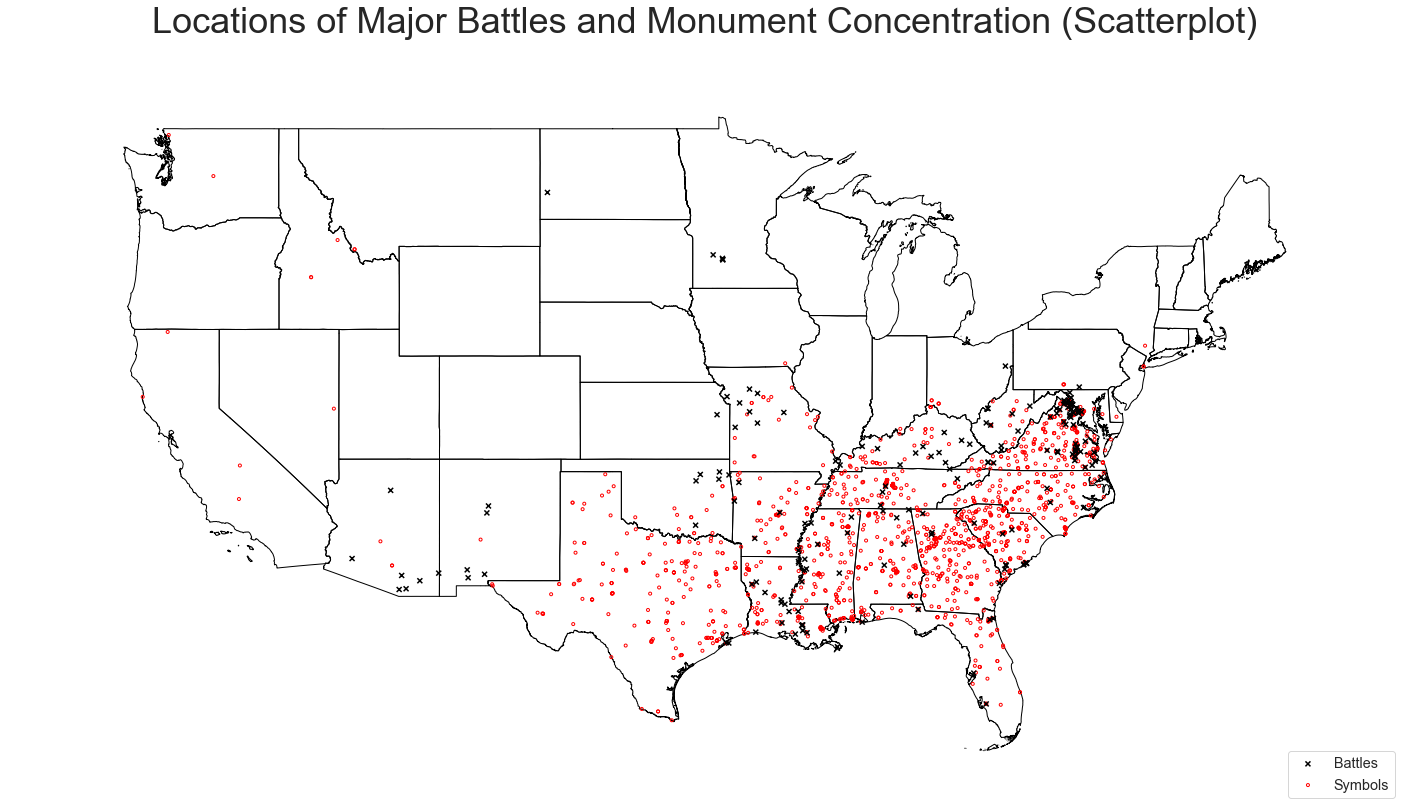

In [42]:
ax = gplt.pointplot(battledf, projection = gplt.crs.Mercator(), color='black', marker='x', zorder=2, figsize=(25,25),
                    label='Battles')
gplt.pointplot(gdf, ax=ax, s=3, color='none', edgecolors='red', zorder=1, label='Symbols')
gplt.polyplot(statemap, ax=ax, zorder=0)

plt.title('Locations of Major Battles and Monument Concentration (Scatterplot)', fontdict={'fontsize':36})
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('battles_scatter.png', bbox_inches='tight')
plt.show()

### Confederate Leader Birthplaces
Next, we look at a grab-bag of coordinates describing where various major leaders of the Confederacy were born. Another possibility is that monuments might be focused where Confederate leaders come from in addition to areas with certain demographics.  

Admittedly, this list is not complete, but it covers at least all of the major relatively well-known leaders of the Confederacy.

In [43]:
gendf = pd.read_csv('civilwar/generals.csv')
geometry = [Point(xy) for xy in zip(gendf['Longitude'], gendf['Latitude'])]
gendf = gpd.GeoDataFrame(gendf, crs={'init': 'epsg:4326'}, geometry=geometry)  # data on leader birthplaces packed into gdf
gendf

,Name,Latitude,Longitude,Place,geometry
0,Robert E Lee,38.151944,-76.839500,"Stratford, VA",POINT (-76.83950 38.15194)
1,JEB Stuart,36.563333,-80.554444,Laurel Hill Farm,POINT (-80.55444 36.56333)
2,James Longstreet,33.832778,-81.801111,"Edgefield District, SC",POINT (-81.80111 33.83278)
3,Stonewall Jackson,39.283333,-80.350000,"Clarksburg, VA",POINT (-80.35000 39.28333)
4,Braxton Bragg,36.400278,-78.156944,"Warrenton, NC",POINT (-78.15694 36.40028)
5,Jefferson Davis,36.843333,-87.303889,"Fairview, KY",POINT (-87.30389 36.84333)
6,PGT Beauregard,29.890000,-89.350000,"St Bernard Parish, LA",POINT (-89.35000 29.89000)
7,John Bell Hood,38.142778,-83.766111,"Owingsville, KY",POINT (-83.76611 38.14278)
8,George Pickett,37.533333,-77.466667,"Richmond, VA",POINT (-77.46667 37.53333)
9,Simon Bolivar Buckner,37.276667,-85.897778,"Munfordville, KY",POINT (-85.89778 37.27667)


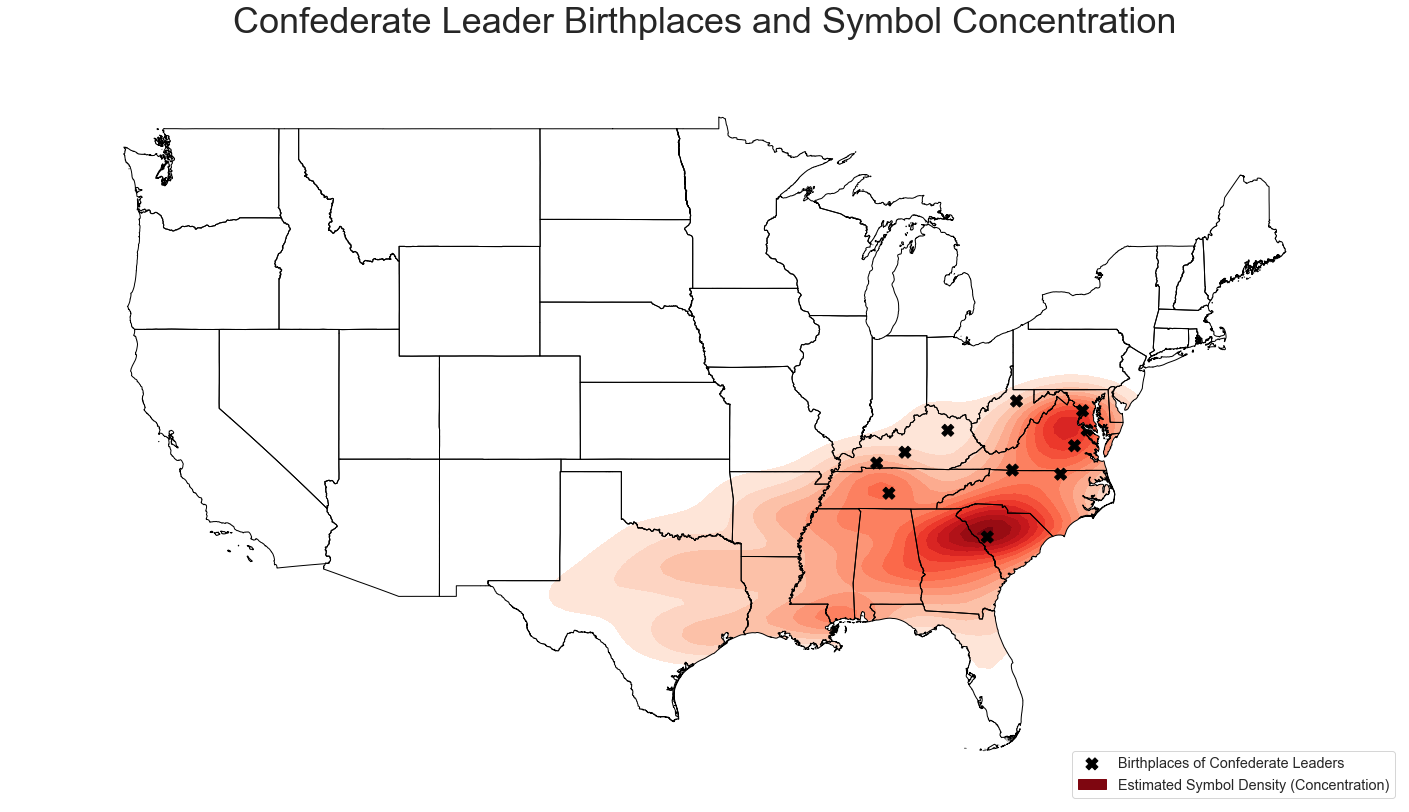

In [44]:
ax = gplt.pointplot(gendf, projection=gplt.crs.Mercator(), marker='X', s=12, color='Black', figsize=(25,25), zorder=1,
                    label='Birthplaces of Confederate Leaders')
gplt.kdeplot(gdf, ax=ax, clip=statemap['geometry'], cmap='Reds', n_levels=15, shade=True, zorder=0,
             label='Estimated Symbol Density (Concentration)')
gplt.polyplot(statemap, ax=ax, zorder=2)

plt.title('Confederate Leader Birthplaces and Symbol Concentration', fontdict={'fontsize':36})
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('leaders_plot.png', bbox_inches='tight')
plt.show()

With few data points, it's hard to come away with anything conclusive. In some cases it seems like monuments tend to cluster in areas where many Confederate leaders were born (like Virginia, South Carolina) but clearly many were also born outside of the hotspots (like in Kentucky or West Virginia). As before, Virginia continues to be in many ways a general center of the whole Civil War.  

Again, since a list of leaders is bound to be short in any case, this doesn't introduce many new data or much information. However, if anything this shows that symbol concentration doesn't really follow leader birthplaces.

### References:

main confederate symbol data: https://www.splcenter.org/20190201/whose-heritage-public-symbols-confederacy
countymap: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html  
statemap: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html (same ^)  
censusdata: https://www.kaggle.com/muonneutrino/us-census-demographic-data  
battles: https://en.wikipedia.org/wiki/Category:Battles_of_the_American_Civil_War  
generals: Generated by personal research  
1900s in racial justice: Generated by personal research
https://en.wikipedia.org/wiki/Jim_Crow_laws#Historical_development
https://en.wikipedia.org/wiki/Lost_Cause_of_the_Confederacy#History